# Определение перспективного тарифа для телеком-компании

# Описание проекта

    Компания «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
    
    Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
     - минута разговора: 3 рубля
     - сообщение: 3 рубля
     - 1 Гб интернет-трафика: 200 рублей

    Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
     - минута разговора: 1 рубль
     - сообщение: 1 рубль
     - 1 Гб интернет-трафика: 150 рублей

    Примечание «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

# Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import stats as st

## Подготовка и изучение данных

In [68]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')


### Данные из Звонки

In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [8]:
calls['id'] = calls['id'].astype('int') 


In [9]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int') 

In [10]:
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


### Данные из Интернет

In [11]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [13]:
internet['id'] = internet['id'].astype('int')

In [14]:
internet.describe()

,Unnamed: 0,id,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00","149,396.00"
mean,"74,697.50","896,847.46",370.19,"1,252.10"
std,"43,127.05","541,975.78",278.30,144.05
min,0.00,"10,000.00",0.00,"1,000.00"
25%,"37,348.75","138,987.75",138.19,"1,130.00"
50%,"74,697.50","1,145,212.50",348.01,"1,251.00"
75%,"112,046.25","1,321,559.25",559.55,"1,380.00"
max,"149,395.00","1,499,156.00","1,724.83","1,499.00"


In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  int64         
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.7 MB


In [16]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Данные из Сообщения

In [17]:
messages.describe()

,user_id
count,"123,036.00"
mean,"1,256.99"
std,143.52
min,"1,000.00"
25%,"1,134.00"
50%,"1,271.00"
75%,"1,381.00"
max,"1,499.00"


In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [19]:
messages['id'] = messages['id'].astype('int')

In [20]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


### Данные из Тарифы

In [21]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
std,671.75,"10,861.16","1,767.77",989.95,35.36,1.41,1.41
min,50.00,"15,360.00",500.00,550.00,150.00,1.00,1.00
25%,287.50,"19,200.00","1,125.00",900.00,162.50,1.50,1.50
50%,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
75%,762.50,"26,880.00","2,375.00","1,600.00",187.50,2.50,2.50
max,"1,000.00","30,720.00","3,000.00","1,950.00",200.00,3.00,3.00


In [23]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Данные из Пользователи

In [24]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [25]:
users.describe()

,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [27]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [29]:
calls.duplicated().sum()

0

In [30]:
messages.duplicated().sum()

0

In [31]:
internet.duplicated().sum()

0

In [32]:
tariffs.duplicated().sum()

0

In [33]:
users.duplicated().sum()

0

#### Вывод

    - Формат дат приведен к нужному типу
    - Явные дубликаты не обнаружены
    - Пропуски не обнаружены

## Исследовательский анализ данных

<br> Произведем расчет:
<br> - количество сделанных звонков и израсходованных минут разговора по месяцам;
<br> - количество отправленных сообщений по месяцам;
<br> - объем израсходованного интернет-трафика по месяцам;
<br> - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

### **Вычислим количество сделанных звонков и израсходованных минут разговора по месяцам**

In [34]:
calls['month'] = calls['call_date'].dt.month_name()
calls.head(5)

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,July
1,10001,2018-08-17,0,1000,August
2,10002,2018-06-11,3,1000,June
3,10003,2018-09-21,14,1000,September
4,10004,2018-12-15,6,1000,December


In [35]:
users_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'month_calls_total'})


In [36]:
users_calls.head(10)

,user_id,month,month_calls_duration,month_calls_total
0,1000,August,408,52
1,1000,December,333,46
2,1000,July,340,47
3,1000,June,172,43
4,1000,May,159,22
5,1000,November,338,43
6,1000,October,350,57
7,1000,September,466,58
8,1001,December,414,63
9,1001,November,430,59


### **Вычислим количество отправленных сообщений по месяцам**

In [37]:
messages['month'] = messages['message_date'].dt.month_name()
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,June
1,10001,2018-10-08,1000,October
2,10002,2018-08-04,1000,August
3,10003,2018-06-16,1000,June
4,10004,2018-12-05,1000,December


In [38]:
users_messages = messages.groupby(['user_id', 'month'])\
                  .agg({'id':'count'})\
                  .reset_index()\
                  .rename(columns={'id':'month_messages_total'})


In [39]:
users_messages.head()

,user_id,month,month_messages_total
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


### **Вычислим объем израсходованного интернет-трафика по месяцам**

In [40]:

internet['month'] = internet['session_date'].dt.month_name()
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,10000,112.95,2018-11-25,1000,November
1,1,10001,"1,052.81",2018-09-07,1000,September
2,2,10002,"1,197.26",2018-06-25,1000,June
3,3,10003,550.27,2018-08-22,1000,August
4,4,10004,302.56,2018-09-24,1000,September


In [41]:

users_internet = internet.groupby(['user_id', 'month'])\
                         .agg({'mb_used':'sum'})\
                         .reset_index()\
                         .rename(columns={'mb_used':'month_mb_total'})
                      


In [42]:
users_internet.head()

,user_id,month,month_mb_total
0,1000,August,"14,055.93"
1,1000,December,"9,817.61"
2,1000,July,"14,003.64"
3,1000,June,"23,233.77"
4,1000,May,"2,253.49"


### **Вычислим помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)**

In [43]:
#мердж'им таблицы
df = users_calls.merge(users_messages, on=['user_id','month'], how='outer').merge(users_internet, on=['user_id','month'], how='outer')
df.head()

,user_id,month,month_calls_duration,month_calls_total,month_messages_total,month_mb_total
0,1000,August,408.00,52.00,81.00,"14,055.93"
1,1000,December,333.00,46.00,70.00,"9,817.61"
2,1000,July,340.00,47.00,75.00,"14,003.64"
3,1000,June,172.00,43.00,60.00,"23,233.77"
4,1000,May,159.00,22.00,22.00,"2,253.49"


In [44]:
tariffs=tariffs.rename(columns={'tariff_name':'tariff'})
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [45]:
df = df.merge(users, on='user_id', how='left').merge(tariffs, on='tariff',how='left')
df.head()

,user_id,month,month_calls_duration,month_calls_total,month_messages_total,month_mb_total,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,408.00,52.00,81.00,"14,055.93",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,December,333.00,46.00,70.00,"9,817.61",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,July,340.00,47.00,75.00,"14,003.64",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,June,172.00,43.00,60.00,"23,233.77",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,May,159.00,22.00,22.00,"2,253.49",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [46]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration       40
month_calls_total          40
month_messages_total      497
month_mb_total             11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [47]:
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['month_calls_total'] = df['month_calls_total'].fillna(0)
df['month_messages_total'] = df['month_messages_total'].fillna(0)
df['month_mb_total'] = df['month_mb_total'].fillna(0)
df.isna().sum()


user_id                     0
month                       0
month_calls_duration        0
month_calls_total           0
month_messages_total        0
month_mb_total              0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [48]:
def total_tariff(row):
    sms = (row['month_messages_total'] - row['messages_included']) * row['rub_per_message']
    mins = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.floor((row['month_mb_total'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
   
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total

In [49]:
df['total_tariff'] = df.apply(lambda x: total_tariff(x), axis=1)
df['full_payment'] = df['rub_monthly_fee'] + df['total_tariff']
df.sort_values(by='full_payment').tail(10)

,user_id,month,month_calls_duration,month_calls_total,month_messages_total,month_mb_total,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total_tariff,full_payment
1494,1240,August,457.00,54.00,0.00,"48,351.59",30,NaT,Воронеж,Зинаида,Шарова,2018-02-27,ultra,1000,30720,3000,1950,150,1,1,"2,582.00","4,532.00"
1621,1261,November,738.00,117.00,25.00,"32,503.56",46,NaT,Казань,Мадина,Пантелеева,2018-10-30,smart,50,15360,500,550,200,3,3,"4,062.00","4,612.00"
783,1124,October,"1,225.00",152.00,121.00,"49,745.69",54,NaT,Махачкала,Альбин,Андрианов,2018-09-24,ultra,1000,30720,3000,1950,150,1,1,"2,786.00","4,736.00"
610,1098,December,588.00,80.00,14.00,"36,523.90",39,NaT,Челябинск,Элеонора,Озерова,2018-06-23,smart,50,15360,500,550,200,3,3,"4,397.00","4,947.00"
999,1159,December,734.00,110.00,2.00,"35,135.89",64,NaT,Красноярск,Эльга,Аничкина,2018-11-28,smart,50,15360,500,550,200,3,3,"4,564.00","5,114.00"
1792,1286,December,739.00,95.00,68.00,"35,108.07",19,NaT,Москва,Рашид,Троицкий,2018-11-27,smart,50,15360,500,550,200,3,3,"4,628.00","5,178.00"
3105,1486,November,764.00,108.00,96.00,"36,266.11",35,NaT,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,50,15360,500,550,200,3,3,"5,013.00","5,563.00"
259,1042,December,728.00,121.00,75.00,"37,165.69",42,NaT,Хабаровск,Константин,Добрынин,2018-11-25,smart,50,15360,500,550,200,3,3,"5,017.00","5,567.00"
1620,1261,December,"1,074.00",141.00,22.00,"32,650.91",46,NaT,Казань,Мадина,Пантелеева,2018-10-30,smart,50,15360,500,550,200,3,3,"5,099.00","5,649.00"
3104,1486,December,"1,007.00",133.00,83.00,"38,552.45",35,NaT,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,50,15360,500,550,200,3,3,"6,149.00","6,699.00"


In [50]:
#df['full_payment'].sum()

#### Вывод 
<br> Произведен расчет сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячную выручку с каждого пользователя. Интересно было наблюдать как часто люди пользуются интернетом, смс, сколько проводят времени разговаривая по телефону, сколько тратят средств на связь, и стало интересно сколько зарабатывает оператор сотовой связи.

# 2 Анализ данных

**Описание поведение клиентов оператора, исходя из выборки: 
<br> - Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? <br> - Посчитайте среднее количество, дисперсию и стандартное отклонение. 
<br> - Постройте гистограммы. 
<br> - Опишите распределения.**

In [51]:
display(df['tariff'].value_counts())
df[['total_tariff', 'full_payment']].describe()

smart    2229
ultra     985
Name: tariff, dtype: int64

,total_tariff,full_payment
count,"3,214.00","3,214.00"
mean,505.36,"1,484.42"
std,731.87,782.82
min,0.00,550.00
25%,0.00,691.25
50%,104.00,"1,557.50"
75%,835.00,"1,950.00"
max,"6,149.00","6,699.00"


Text(0.5, 1.0, 'tariff - Smart')

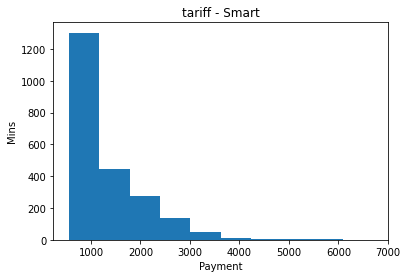

In [52]:
df[df['tariff'] == 'smart']['full_payment'].plot(kind='hist', bins=10)
plt.xlabel("Payment")
plt.ylabel("Mins")
plt.title('tariff - Smart')


Text(0.5, 1.0, 'tariff - Ultra')

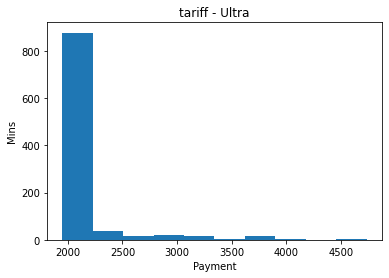

In [53]:
df[df['tariff'] == 'ultra']['full_payment'].plot(kind='hist', bins=10)
plt.xlabel("Payment")
plt.ylabel("Mins")
plt.title('tariff - Ultra')


In [54]:
df.groupby('tariff').agg({'full_payment':['median','mean','var','std']})

full_payment                           
             median     mean        var    std
tariff                                        
smart        957.00 1,230.16 617,119.36 785.57
ultra      1,950.00 2,059.80 125,843.21 354.74

#### **Вывод** 
На тарифе Смарт среднее и медиана не так далеко друг от друга, но перепличивает много пользователей, в среднем в 2 раза, можно сделать вывод, что кому-то мало интернета, звонков, чтобы не потерять клиентом, оператору можно придумать тариф, который будет между смарт и ультра, тогда много пользователей будут довольны. На тарифе Ультра средняя и медиана близки к друг другу, переплата у пользователей за тариф не такая большая, как на Смарт.

Text(0.5, 1.0, 'Звонки в минутах в месяц по тарифу Smart')

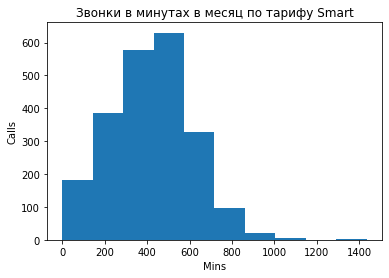

In [55]:
df[df['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.xlabel("Mins")
plt.ylabel("Calls")
plt.title('Звонки в минутах в месяц по тарифу Smart')

Text(0.5, 1.0, 'Звонки в минутах в месяц по тарифу Ultra')

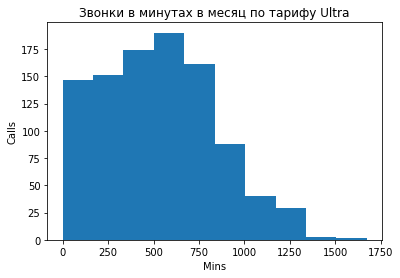

In [56]:
df[df['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.xlabel("Mins")
plt.ylabel("Calls")
plt.title('Звонки в минутах в месяц по тарифу Ultra')

In [57]:
df.groupby('tariff').agg({'month_calls_duration':['median','mean','var','std']})

month_calls_duration                         
                     median   mean        var    std
tariff                                              
smart                422.00 417.93  36,219.32 190.31
ultra                518.00 526.62 100,873.63 317.61

**Вывод** На тарифе Смарт в среднем расходуют 400 минут, большая часть укладывается, но есть те, кто любит поговорить чуть больше; На тарифе Ультра в среднем расходуют 500 минут, что намного меньше, чем входит в тариф. Средняя и медиана близки, нереальных значений не наблюдается, все в пределах нормы.

Text(0.5, 1.0, 'Пользование интернетом в МБ в месяц по тарифу Smart')

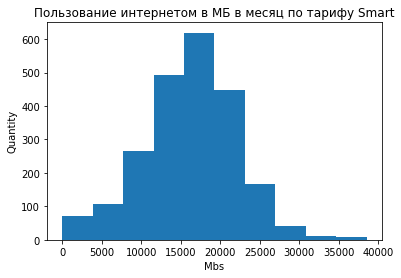

In [58]:
df[df['tariff'] == 'smart']['month_mb_total'].plot(kind='hist', bins=10)
plt.xlabel("Mbs")
plt.ylabel("Quantity")
plt.title('Пользование интернетом в МБ в месяц по тарифу Smart')

Text(0.5, 1.0, 'Пользование интернетом в МБ в месяц по тарифу Ultra')

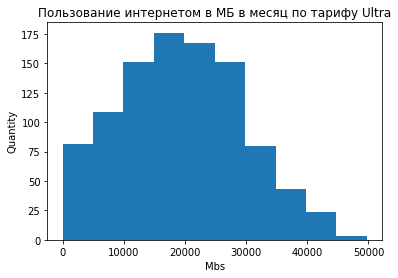

In [59]:
df[df['tariff'] == 'ultra']['month_mb_total'].plot(kind='hist', bins=10)
plt.xlabel("Mbs")
plt.ylabel("Quantity")
plt.title('Пользование интернетом в МБ в месяц по тарифу Ultra')

In [60]:
df.groupby('tariff').agg({'month_mb_total':['median','mean','var','std']})

month_mb_total                                   
               median      mean            var       std
tariff                                                  
smart       16,506.84 16,208.39  34,462,496.46  5,870.48
ultra       19,308.01 19,468.81 101,751,013.78 10,087.17

**Вывод** На тарифе Смарт в среднем в месяц расходуют 16 гб, медиана и среднее близки к друг другу, но есть те, кто очень любит просматривать соцсети, смотреть видео, фильмы, и выбиваются из предоставленного лимита на ГБ; На тарифе Ультра в среднем в месяц расходуют 19 гб, медианы близки к друг другу процент тех, кто выходит за пределы предоставленного лимит, намного меньше чем на Смарте. В целом нереальных значений нет, все в пределах нормы.

Text(0.5, 1.0, 'Отправлено СМС в месяц по тарифу Smart')

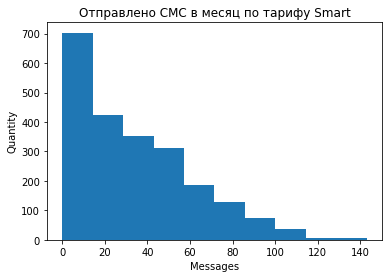

In [61]:
df[df['tariff'] == 'smart']['month_messages_total'].plot(kind='hist', bins=10)
plt.xlabel("Messages")
plt.ylabel("Quantity")
plt.title('Отправлено СМС в месяц по тарифу Smart')

Text(0.5, 1.0, 'Отправлено СМС в месяц по тарифу Ultra')

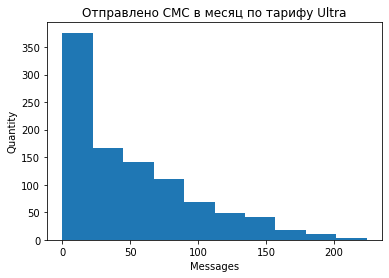

In [62]:
df[df['tariff'] == 'ultra']['month_messages_total'].plot(kind='hist', bins=10)
plt.xlabel("Messages")
plt.ylabel("Quantity")
plt.title('Отправлено СМС в месяц по тарифу Ultra')

In [63]:
df.groupby('tariff').agg({'month_messages_total':['median','mean','var','std']})

month_messages_total                     
                     median  mean      var   std
tariff                                          
smart                 28.00 33.38   796.81 28.23
ultra                 38.00 49.36 2,285.27 47.80

**Вывод** Смсками на обоих тарифах мало кто пользуется, а в правду, зачем, когда есть соц.сети. Но все же в среднем 30-50 смсок в месяц пользователи направляют. Есть пользователи кто в лимиты на тарифе Смарт не укладывается, но их немного!

## Проверка гипотез

**<br> - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
<br> - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

In [64]:
def delete_emissions(df, column, graphic=0, x = 10, y = 10): #функция для удаления выбросов.
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]

**№ 1 Гипотеза о равенстве средних двух генеральных совокупностей 
Формулировка гипотезы:**


<br>H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
<br>H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

<br> Для оценки гипотезы будем применять тест Стюдента. Соотвественно, мы можем получить два ответа "Отвергаем нулевую гипотезу" и "Не получилось отвергнуть нулевую гипотезу".

<br> При получении ответа "Отвергаем нулевую гипотезу" это будет говорить о том, что гипотеза противоречит эмпирическим данным и скорей всего наше предположение неверно. Значит данные различаются.

<br> При получении ответа "Не получилось отвергнуть нулевую гипотезу", это значит что предположение о равенстве средней выручки верно.

In [65]:
ultra = df[df['tariff'] == 'ultra']
smart = df[df['tariff'] == 'smart']
smart = delete_emissions(smart, 'full_payment', 0)
smart = smart['full_payment']
ultra = delete_emissions(ultra, 'full_payment', 0)
ultra = ultra['full_payment']
alpha = 0.05 #критический уровень статистической значимости
results = st.ttest_ind(ultra, smart)
display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")

/tmp/ipykernel_31/4236270601.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results = st.ttest_ind(ultra, smart)


'p-значение:'

2.955636807646232e-203

'Отвергаем нулевую гипотезу'

**Вывод** <br> Выборки по тарифам отличатся от генеральной. Это значит, тарифы вносят ощутимый вклад в среднюю оплату за месяц.

**№2 Гипотеза о равенстве средних двух генеральных совокупностей  
Формулировка гипотезы:**
    
<br>H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
<br>H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

<br> Для оценки гипотезы будем применять тест Стюдента. Соотвественно, мы можем получить два ответа "Отвергаем нулевую гипотезу" и "Не получилось отвергнуть нулевую гипотезу".

<br> При получении ответа "Отвергаем нулевую гипотезу" это будет говорить о том, что гипотеза противоречит эмпирическим данным и скорей всего наше предположение неверно. Значит данные различаются.

<br> При получении ответа "Не получилось отвергнуть нулевую гипотезу", это значит что предположение о равенстве средней выручки верно.

In [66]:
df['city'].unique() # Создадим выборку для города Москва и всех остальных регионов

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [67]:
df['region'] = np.where(df['city'] == 'Москва', 'Москва', 'Провинция')
moscow = df[df['region'] == 'Москва']
province = df[df['region'] == 'Провинция']
moscow = delete_emissions(moscow, 'total_paid', 0)
moscow = moscow['total_paid']
province = delete_emissions(province, 'total_paid', 0)
province = province['total_paid']
results = st.ttest_ind(moscow, province)
display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")



KeyError: 'total_paid'

**Вывод** <br> Данный ответ означает, разницы между средней выручки Москвы и остальных городов нет.

<br> При сравнении статистических данных по выборкам с генеральной выборкой можно увидить, что данные соотвествуют нормальному распределению в независимсости от выбранного города.



# 4 Общий вывод

<br> Проанализирована каждая таблица, выявлены аномалии и связи между ними.
<br> Составлена общая таблица данных о пользователях сети
<br> Заполнены пропуски 
<br> Проведен сравнительный анализ пользователей тарифов
<br> Проверены гипотезы на возможное соотвествие
<br> Предложенные тарифы сильно отличаются друг от друга, соответственно их выручка разная. Пользователи тарифа Смарт чаще пользователей тарифа Ultra перерасходывют лимиты тарифов. Из этого следует, что выручка по тарифу Смарт больше.

<br> При сравнении расходов пользователей, можно сделать вывод, что первый тариф не соответвует большинству пользователей практически по всем пунктам (более половины случаев переплат только за интернет). По тарифу Смарт заявленный лимит по минутам и смс практически не расходуется в полном объеме, перерасход может быть только за интернету.

<br> На основании статистического анализа: распределения данных находяться на разных значениях выручки и не может быть похожими друг на друга.

<br> Разницы по местоположению пользователя нет как в общем, так и отдельно по тарифам. Средняя выручка за тариф не отличается.


<br> Были выдвинуты две гипотезы:

<br> Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
<br> Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
<br> Гипотеза 1 подтвердилась и говорит нам о том, что выручка по тарифамм отличается, но можно предположить, что на тарифе Ультра выручки больше, чем на тарифе Смарт.

<br> Гипотеза 2 была опровергнута. Это значит, что нормальное распределение по выручке за месяц между городом Москва и остальной страной не отличается.

**Рекомендации оператору:**
<br>Предложенные тарифы сильно отличаются друг от друга, соответственно их выручка разная. Пользователи тарифа Смарт чаще пользователей тарифа Ultra перерасходывют лимиты тарифов. Из этого следует, что выручка по тарифу Смарт больше. 
<br>Оператору я бы рекомендовал оптимизировать тариф, например назвать тариф Medium, в котором будут средние тарифы взятые от Ультра и Смарт. А если оставить выборку между двумя, то рекламировать конечно же тариф Смарт. 